In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import model_selection

In [2]:
import copy

# Load data

In [3]:
# Mikel path
#data = pd.read_csv('/Users/mikelyu/Desktop/Uni/02455 Statistical Evaluation/02455-projects/HR_data.csv')

# Karl path
df = pd.read_csv(r"C:\desktop\02455-projects\HR_data.csv")

print(df.head())

   Unnamed: 0    HR_Mean  HR_Median    HR_std  HR_Min  HR_Max     HR_AUC  \
0           0  77.965186      78.00  3.345290   73.23   83.37  22924.945   
1           1  70.981097      70.57  2.517879   67.12   78.22  21930.400   
2           2  73.371959      73.36  3.259569   67.88   80.22  21647.085   
3           3  78.916822      77.88  4.054595   72.32   84.92  25258.905   
4           4  77.322226      74.55  6.047603   70.52   90.15  23890.565   

     Round   Phase  Individual  Puzzler  Frustrated Cohort  
0  round_3  phase3           1        1           1   D1_1  
1  round_3  phase2           1        1           5   D1_1  
2  round_3  phase1           1        1           0   D1_1  
3  round_2  phase3           1        1           1   D1_1  
4  round_2  phase2           1        1           5   D1_1  


No missing values.

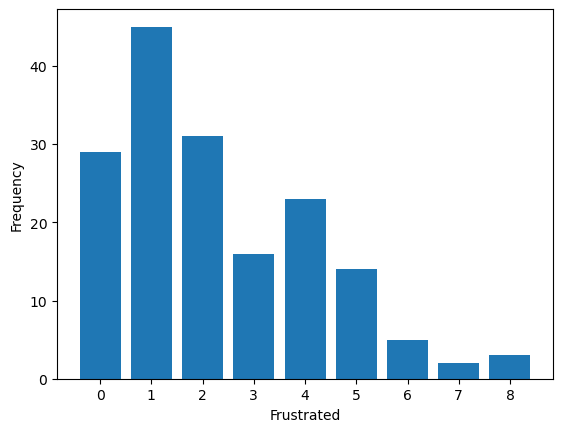

In [4]:
min_value = df['Frustrated'].min()
max_value = df['Frustrated'].max()
bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)  # Add and subtract 0.5 to center bins

# Create the histogram with customized settings
plt.hist(df['Frustrated'], bins=bin_edges, align='mid', rwidth=0.8)  # Adjust rwidth for spacing

# Customize tick marks and labels
plt.xticks(range(min_value, max_value + 1)) 
plt.xlabel('Frustrated')
plt.ylabel('Frequency')
plt.show()

In [5]:
for column in df.columns:
    globals()[column] = df[column].tolist()

# visualization

Frustration is discrete variable. Therefore, each value from 0-10 can be seen as a discrete and separated value. We can thus view this as a classification problem. Therefore, we will attempt to fit two classification models to the data.

# Models

## Classification

In [6]:
# Display the first few rows of the dataframe
print(df.head())

# Display information about the dataframe
print(df.info())

X = df.drop(["Unnamed: 0",'Frustrated',"Individual","Puzzler","Cohort","Phase","Round"], axis=1)

X

   Unnamed: 0    HR_Mean  HR_Median    HR_std  HR_Min  HR_Max     HR_AUC  \
0           0  77.965186      78.00  3.345290   73.23   83.37  22924.945   
1           1  70.981097      70.57  2.517879   67.12   78.22  21930.400   
2           2  73.371959      73.36  3.259569   67.88   80.22  21647.085   
3           3  78.916822      77.88  4.054595   72.32   84.92  25258.905   
4           4  77.322226      74.55  6.047603   70.52   90.15  23890.565   

     Round   Phase  Individual  Puzzler  Frustrated Cohort  
0  round_3  phase3           1        1           1   D1_1  
1  round_3  phase2           1        1           5   D1_1  
2  round_3  phase1           1        1           0   D1_1  
3  round_2  phase3           1        1           1   D1_1  
4  round_2  phase2           1        1           5   D1_1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC
0,77.965186,78.000,3.345290,73.23,83.37,22924.945
1,70.981097,70.570,2.517879,67.12,78.22,21930.400
2,73.371959,73.360,3.259569,67.88,80.22,21647.085
3,78.916822,77.880,4.054595,72.32,84.92,25258.905
4,77.322226,74.550,6.047603,70.52,90.15,23890.565
...,...,...,...,...,...,...
163,73.594539,72.380,9.474556,57.43,93.53,21482.985
164,57.839897,54.130,6.796647,52.97,74.14,16825.740
165,64.237295,65.195,3.589241,58.97,72.63,18691.065
166,70.834320,70.440,2.391160,66.65,76.07,20753.005


In [7]:
y = df['Frustrated']

In [8]:
from sklearn.preprocessing import StandardScaler

numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Check mean and standard deviation
print(X[numeric_columns].mean())
print(X[numeric_columns].std())


HR_Mean      2.379049e-16
HR_Median   -7.797995e-16
HR_std      -4.229421e-17
HR_Min      -8.035900e-16
HR_Max      -1.015061e-15
HR_AUC      -3.700743e-16
dtype: float64
HR_Mean      1.00299
HR_Median    1.00299
HR_std       1.00299
HR_Min       1.00299
HR_Max       1.00299
HR_AUC       1.00299
dtype: float64


In [9]:
y.value_counts()

Frustrated
1    45
2    31
0    29
4    23
3    16
5    14
6     5
8     3
7     2
Name: count, dtype: int64

In [10]:
for i in range(len(y)):
    if y.iat[i] > 2.5:
        y.iat[i] = 1
    else:
        y.iat[i] = 0

In [11]:
X_R = []
for i in range(14):
    globals()[f'individual_{i}'] = X[(i*12):((i+1)*12)]
    X_R.append(globals()[f'individual_{i}'])

y_R = []

for i in range(14):
    y_R.append(y[(i*12):((i+1)*12)])

In [12]:
# Initialize lists to hold results
y_true = []
y_pred = []

i = 0

X_test = X_R[i]
X_train_p = copy.deepcopy(X_R)
X_train_p.pop(i)

y_test = y_R[i]
y_train_p = copy.deepcopy(y_R)
y_train_p.pop(i)

X_train = pd.concat(X_train_p)
y_train = pd.concat(y_train_p)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred.append(model.predict(X_test))
y_true.append(y_test.values)

# Calculate accuracy
accuracy = accuracy_score(y_true[0], y_pred[0])
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5833


In [13]:
# Initialize lists to hold results
accuracy_RF = []
# Perform LOOCV
for i in range(len(X_R)):
    y_true = []
    y_pred = []
    X_test = X_R[i]
    X_train_p = copy.deepcopy(X_R)
    X_train_p.pop(i)

    y_test = y_R[i]
    y_train_p = copy.deepcopy(y_R)
    y_train_p.pop(i)

    X_train = pd.concat(X_train_p)
    y_train = pd.concat(y_train_p)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred.append(model.predict(X_test))
    y_true.append(y_test.values)

    accuracy_RF.append(accuracy_score(y_true[0], y_pred[0]))

In [14]:
# Initialize lists to hold results
accuracy_LR = []

# Perform LOOCV
for i in range(len(X_R)):
    y_true = []
    y_pred = []
    X_test = X_R[i]
    X_train_p = copy.deepcopy(X_R)
    X_train_p.pop(i)

    y_test = y_R[i]
    y_train_p = copy.deepcopy(y_R)
    y_train_p.pop(i)

    X_train = pd.concat(X_train_p)
    y_train = pd.concat(y_train_p)

    # Initialize and train the model
    model = LogisticRegression(random_state=42, max_iter=100000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred.append(model.predict(X_test))
    y_true.append(y_test.values)

    accuracy_LR.append(accuracy_score(y_true[0],y_pred[0]))

In [15]:
# Initialize lists to hold results
accuracy_BL = []
mk1 = []
mk2 = []

# Perform LOOCV
for i in range(len(X_R)):
    y_true = []
    y_pred = []

    y_test = y_R[i]
    y_train_p = copy.deepcopy(y_R)
    y_train_p.pop(i)

    X_train = pd.concat(X_train_p)
    y_train = pd.concat(y_train_p)

    # Initialize and train the model
    class_0 = 0
    class_1 = 0
    for i in range(len(y_train)):
        if y_train.iat[i] > 0.5:
            class_1 += 1
        else:
            class_0 += 1
    
    C1 = False

    if class_1 > class_0:
        C1 = True

    
    if C1 == True:
        y_pred = [pd.DataFrame([1]*len(y_test))]
    else:
        y_pred = [pd.DataFrame([0]*len(y_test))]
            

    # Make predictions
    y_true.append(y_test.values)

    accuracy_BL.append(accuracy_score(y_true[0],y_pred[0]))
    

In [16]:
np.mean(accuracy_BL)

0.625

In [17]:
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(accuracy_RF, accuracy_LR)


In [18]:
np.mean(accuracy_LR)

0.5654761904761905

In [19]:
np.mean(accuracy_RF)

0.5238095238095238